In [1]:
from global_variable import *

In [2]:
import random
import networkx as nx
import math
import itertools    
import matplotlib.pyplot as plt
import ast
import numpy as np
import operator
from sklearn.cluster import KMeans
from collections import defaultdict


In [3]:
with open('sensor_for_large_Grid1000_30sensorlistonly.txt', 'r') as f:
    sensor = ast.literal_eval(f.read())

In [4]:
length_of_grid

1000

In [5]:
 sensor=sorted(sensor)

In [6]:
sensor

[(108, 452),
 (130, 409),
 (145, 826),
 (179, 404),
 (199, 230),
 (204, 628),
 (263, 665),
 (323, 319),
 (324, 456),
 (347, 837),
 (367, 899),
 (371, 717),
 (470, 770),
 (492, 310),
 (536, 624),
 (539, 557),
 (578, 311),
 (602, 38),
 (624, 567),
 (642, 530),
 (647, 745),
 (650, 381),
 (667, 360),
 (702, 829),
 (759, 148),
 (845, 401),
 (849, 691),
 (905, 608),
 (958, 562),
 (988, 418)]

In [7]:
s=[list(i) for i in sensor]

In [8]:
X=np.array(s)

## function just to calculate distance between two pdp points

In [9]:
def distance(points,i,j):
    x=points[i][0]-points[j][0]
    y=points[i][1]-points[j][1]
    return math.sqrt(x*x+y*y)

## Function to determine the pdp position in the grid

In [10]:
def calculate_Pdp_positions(length_of_grid,transmission_range):
    pdp_positions={}
    k=0
    for c_1 in np.arange(length_of_grid/(transmission_range*math.sqrt(2))):
        for c_2 in np.arange(length_of_grid/(transmission_range*math.sqrt(2))):
            pdp_positions[k]=(c_1*transmission_range*math.sqrt(2),c_2*transmission_range*math.sqrt(2))
            k=k+1
    threshold_grid_size=c_1*transmission_range*math.sqrt(2)
    return pdp_positions,threshold_grid_size

In [11]:
pdp_positions,threshold=calculate_Pdp_positions(length_of_grid,transmission_range)

## Function to create the trip graph

In [12]:
threshold

989.9494936611666

In [13]:
def create_trip_graph():
    G=nx.Graph()
    distance_between_pdp={}
    for i in range(len(pdp_positions)):
        G.add_node('pdp{}'.format(i),pos=pdp_positions[i])
    for u in range(len(pdp_positions)):
        for v in range(len(pdp_positions)):
            wt=distance(pdp_positions,u,v)
            G.add_edge('pdp{}'.format(u),'pdp{}'.format(v),weight=wt)
            distance_between_pdp[(u,v)]=wt
    return G,distance_between_pdp

In [14]:
trip_graph,distance_between_pdp=create_trip_graph()

## This function calculates the pdp with the minimum distance betweeen the cluster center

In [15]:
def calculate_min_pdp_distance_with_cluster_center(c_centers,pdp_positions):
    """
    Function to calculate the nearest pdp_position to the cluster center 
    """
    new_dict={}
    for i in c_centers:
        temp={}
        for p,value in pdp_positions.items():
            arr=np.array(value)
            #print(arr)
            dist=np.linalg.norm(i-arr)
            temp[p]=dist
        #print(temp)
        print(min(temp.items(),key=operator.itemgetter(1))[0])
        print(min(temp.items(),key=operator.itemgetter(1))[1])
        print("******")
        new_dict[tuple(i)]=min(temp.items(),key=operator.itemgetter(1))[0]

    return new_dict

In [16]:
K=nx.DiGraph()

In [17]:
for i in range(len(sensor)):
    K.add_node('sensor{}'.format(i),pos=sensor[i])

In [18]:
def calulate_distance_between_each_sensors_and_assign_weight(points,K):
    distance_sensors={}
    M=K
    k=0
    edge_weight=1
    for i in range(len(points)):
        for j in range(len(points)):
            euclidean_distance=distance(points,i,j)
            if i!=j:
                #M.add_edge("sensor{}".format(i),"sensor{}".format(j))

                
                if euclidean_distance<=transmission_range:
                    #if M.has_edge('sensor{}'.format(i),'sensor{}'.format(j))!=True:
                    M.add_edge("sensor{}".format(i),"sensor{}".format(j))

                    M["sensor{}".format(i)]["sensor{}".format(j)]['weight']=1

                    distance_sensors[i,j]=(euclidean_distance,edge_weight)
#                 else:
#                     M["sensor{}".format(i)]["sensor{}".format(j)]['weight']=100
#                     distance_sensors[i,j]=(euclidean_distance,100)
#             k=k+1
    return distance_sensors,M

In [19]:
euclidean_distance_between_sensor,L=calulate_distance_between_each_sensors_and_assign_weight(sensor,K)

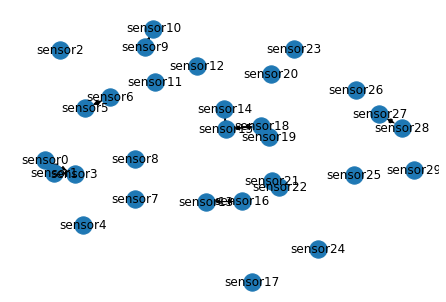

In [20]:
nx.draw(L,nx.get_node_attributes(L,'pos'),with_labels=True)

In [21]:
def distance_pdp_sensors(pdp_positions,sensor,u,v):
    x=pdp_positions[u][0]-sensor[v][0]
    y=pdp_positions[u][1]-sensor[v][1]
    return math.sqrt(x*x+y*y)

## Function that is used for creating the conncectivity graph

In [22]:
def connectivity_graph(pdp_positions,sensor,K):
    J=K
    distance_pdp_each_sensor={}
    k=0
    weight=1
    for i in range(len(pdp_positions)):
        J.add_node('pdp{}'.format(i),pos=pdp_positions[i])
    for u in range(len(pdp_positions)):
        for v in range(len(sensor)):
            euclidean_distance_between_pdp_sensor=distance_pdp_sensors(pdp_positions,sensor,u,v)
            J.add_edge("pdp{}".format(u),"sensor{}".format(v))
            
            if euclidean_distance_between_pdp_sensor<=transmission_range:
                #J.add_edge("pdp{}".format(u),"sensor{}".format(v))
                #if J.has_edge('pdp{}'.format(i),'sensor{}'.format(j))!=True:
                    #J.add_edge("pdp{}".format(u),"sensor{}".format(v))
               
                
                J["pdp{}".format(u)]["sensor{}".format(v)]['weight']=1
                distance_pdp_each_sensor[u,v]=euclidean_distance_between_pdp_sensor,weight
            else:
                J["pdp{}".format(u)]["sensor{}".format(v)]['weight']=100
                distance_pdp_each_sensor[u,v]=euclidean_distance_between_pdp_sensor,100
#            k=k+1
    return distance_pdp_each_sensor,J

In [23]:
distance_between_pdp_to_each_sensor,N=connectivity_graph(pdp_positions,sensor,L)

# Here it finds the shortest distance between each pdp and 

In [24]:
k=0
arc_length={}
shortest_path={}
for i in range(len(pdp_positions)):
    for j in range(len(sensor)):
        if N.has_edge('pdp{}'.format(i),'sensor{}'.format(j)):
            shortest_path[i,j]=nx.shortest_path(N,source='pdp{}'.format(i),target='sensor{}'.format(j),
                                              weight='weight',method='dijkstra')
            arc_length[i,j]=nx.dijkstra_path_length(N,'pdp{}'.format(i),'sensor{}'.format(j))
            
           
        else:
            shortest_path[i,j]=0

In [25]:
new_zipped=dict(zip(arc_length.items(),shortest_path.values()))

In [26]:
def spanning_tree_collecting_time(pdp):
    """This function defines which sensors are connected with the desired pdp"""
    """
    return list
    """
    sensor_subset=[]
    for key,value in new_zipped.items():
        if key[0][0]==pdp:
            if key[1]!=100:
                #print(i)
                sensor_subset.append(key[0][1])
    return sensor_subset

In [27]:
def to_check_the_minimum_hops_between_the_pdp_and_sensor(spanning_tree):
    """In this function we check which sensor can send data to the pdp with minimum hops
    for example if sensor2 is connected with pdp10 with  hop distance with 2 and same sensor2 is connected with 
    pdp11 with hop distance 4 then we assume that sensor2 will send data to the drone when drone is at pdp10 since 
    it has minimum hop distance"""
    subset2=spanning_tree
    for key,value in subset2.items():
        for key1,value1 in subset2.items():
            if key!=key1:
                for i in value:
                    for j in value1:
                        if i==j:
                            #print(i)
                            #s=get_number(i)
                            if nx.dijkstra_path_length(N,'pdp{}'.format(key),'sensor{}'.format(i))>nx.dijkstra_path_length(N,'pdp{}'.format(key1),'sensor{}'.format(i)):
                                subset2[key].remove(i)
                            else:
                                subset2[key1].remove(j)
    return subset2

In [28]:
def create_spanning_tree_for_tour(tour):
    sensor_subset={}
    for i in tour:
        sensor_subset[i]=spanning_tree_collecting_time(i)
    correct_sensor_subset=to_check_the_minimum_hops_between_the_pdp_and_sensor(sensor_subset)
    return correct_sensor_subset

In [29]:
def check_all_sensor_can_send_data(checked_sensor_arc):
    """The main aim of creating this function was to check whether all the sensors are connected to the pdps in the route
    of drone tour.For example we have pdp10 and pdp7 in our route.ie Route=[10 7].We create spanning tree for the both 
    the pdps and check whether all the sensors are connected or not.If all the sensors are not connected in the combined
    spanning tree calculated with the pdps of the Route"""
    s=[]
    for key,values in checked_sensor_arc.items():
        s=list(set().union(s,values))
    if len(s)==len(sensor): # before there was only s==sensor but it was wrong as s is list and sensor is a list of tuple
        return 1
    else:
        return 0
    

In [30]:
def determine_collecting_time(checked_sensor_arc):
    """After checking whether all the sensor can send data while the drone makes a trip in the way as
    described in the Route.We assign collecting time as infinite or call the collecting time function"""
    value=check_all_sensor_can_send_data(checked_sensor_arc)
    if value==1:
        t_collecting=calculate_collecting_time(checked_sensor_arc)
    if value==0:
        t_collecting=math.inf
    return t_collecting

In [31]:
def check_all_sensor_can_send_data(checked_sensor_arc):
    """The main aim of creating this function was to check whether all the sensors are connected to the pdps in the route
    of drone tour.For example we have pdp10 and pdp7 in our route.ie Route=[10 7].We create spanning tree for the both 
    the pdps and check whether all the sensors are connected or not.If all the sensors are not connected in the combined
    spanning tree calculated with the pdps of the Route"""
    s=[]
    for key,values in checked_sensor_arc.items():
        s=list(set().union(s,values))
    if len(s)==len(sensor): # before there was only s==sensor but it was wrong as s is list and sensor is a list of tuple
        return 1
    else:
        return 0
    

In [32]:
def calculate_collecting_time(checked_sensor_arc):
    
    dict_={}
    for key,values in checked_sensor_arc.items():
        weight=0
        if values!=[]:
            for j in values:
                for key1,values1 in new_zipped.items():
                    if key1[0]==(key,j):
                        #print(key1[1])
                        weight=weight+key1[1]
                        t_collecting=(data_rate/bandwidth)*weight
        dict_[key]=t_collecting
    return dict_
    

In [33]:
def calc_cluster_number(sensor):
    
    for i in range(1,len(sensor)):
        new_dict={}
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(X)
        c_centers=tuple(kmeans.cluster_centers_)
        for j in c_centers:
            temp={}
            for p,value in pdp_positions.items():
                arr=np.array(value)
                dist=np.linalg.norm(j-arr)
                temp[p]=dist
#           print(temp)
            new_dict[tuple(j)]=min(temp.items(),key=operator.itemgetter(1))[0]
        subset={}
        print(new_dict)
        for key,values in new_dict.items():
            subset[values]=spanning_tree_collecting_time(values)
        checked=to_check_the_minimum_hops_between_the_pdp_and_sensor(subset)
        check=check_all_sensor_can_send_data(checked)
        if check==1:
            print("i am here")
            df_=calculate_collecting_time(checked)
            print(df_)
            break
    return i,new_dict,df_
        
        
            

In [34]:
n,m,o=calc_cluster_number(sensor)

C:\Users\dilip\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


{(513.7666666666668, 523.0666666666667): 36}
{(263.8461538461539, 585.5384615384615): 20, (704.8823529411765, 475.29411764705884): 43}
{(417.3636363636364, 736.0909090909092): 29, (755.5833333333333, 417.91666666666674): 43, (250.71428571428572, 368.57142857142856): 19}
{(711.3333333333333, 634.7777777777778): 44, (210.5, 378.33333333333337): 11, (309.57142857142856, 763.1428571428571): 21, (697.625, 295.87500000000006): 42}
{(615.0, 642.0): 37, (309.57142857142856, 763.1428571428571): 21, (909.0, 536.0): 52, (624.6666666666666, 258.00000000000006): 34, (210.5, 378.33333333333337): 11}
{(596.75, 340.5): 34, (210.5, 378.33333333333337): 11, (309.57142857142856, 763.1428571428571): 21, (909.0, 536.0): 52, (615.0, 642.0): 37, (680.5, 93.0): 41}
{(309.57142857142856, 763.1428571428571): 21, (596.75, 340.5): 34, (210.5, 378.33333333333337): 11, (924.0, 497.25): 60, (732.6666666666666, 755.0): 45, (680.5, 93.0): 41, (585.25, 569.5): 36}
{(680.5, 93.0): 41, (732.6666666666666, 755.0): 45, (20

In [35]:
coordinates=[]
for key,values in o.items():
    for k,v in pdp_positions.items():
        if key==k:
            l=list(v)
            coordinates.append(l)
    

## From here the multiple TSP starts

In [36]:
coordinates

[[989.9494936611666, 565.685424949238],
 [565.685424949238, 565.685424949238],
 [141.4213562373095, 424.26406871192853],
 [565.685424949238, 0.0],
 [424.26406871192853, 707.1067811865476],
 [565.685424949238, 282.842712474619],
 [282.842712474619, 282.842712474619],
 [707.1067811865476, 848.5281374238571],
 [282.842712474619, 707.1067811865476],
 [424.26406871192853, 848.5281374238571],
 [848.5281374238571, 424.26406871192853],
 [141.4213562373095, 848.5281374238571],
 [707.1067811865476, 141.4213562373095],
 [989.9494936611666, 424.26406871192853],
 [848.5281374238571, 707.1067811865476],
 [141.4213562373095, 282.842712474619],
 [707.1067811865476, 424.26406871192853],
 [282.842712474619, 424.26406871192853],
 [707.1067811865476, 707.1067811865476]]

taking just two points as depot at the moment so there will be only two drones

In [37]:
depot=[(0,0),(989.9494936611666
,0)]

Just assigning large value in M

In [38]:
M=1000*1000

Here the distance between each depot and customer is calculated and stored 

In [39]:
dist_dep_cus={}
for i in range(len(depot)):
    for j in range(len(coordinates)):
        dist_dep_cus[i,j]=np.linalg.norm(np.array(depot[i])-np.array(coordinates[j]))

total will have the list of all the depot and coordinates of the customers to be visited

In [40]:
total=depot+coordinates

In [41]:
len(total)

21

In [42]:
dist_dep_cus

{(0, 0): 1140.175425099138,
 (0, 1): 800.0,
 (0, 2): 447.21359549995793,
 (0, 3): 565.685424949238,
 (0, 4): 824.6211251235321,
 (0, 5): 632.4555320336759,
 (0, 6): 400.0,
 (0, 7): 1104.536101718726,
 (0, 8): 761.5773105863908,
 (0, 9): 948.6832980505138,
 (0, 10): 948.6832980505138,
 (0, 11): 860.2325267042627,
 (0, 12): 721.1102550927978,
 (0, 13): 1077.032961426901,
 (0, 14): 1104.536101718726,
 (0, 15): 316.22776601683796,
 (0, 16): 824.6211251235321,
 (0, 17): 509.9019513592785,
 (0, 18): 1000.0000000000001,
 (1, 0): 565.685424949238,
 (1, 1): 707.1067811865476,
 (1, 2): 948.6832980505138,
 (1, 3): 424.26406871192853,
 (1, 4): 905.5385138137417,
 (1, 5): 509.9019513592785,
 (1, 6): 761.5773105863909,
 (1, 7): 894.4271909999159,
 (1, 8): 1000.0000000000001,
 (1, 9): 1019.803902718557,
 (1, 10): 447.21359549995793,
 (1, 11): 1200.0,
 (1, 12): 316.22776601683796,
 (1, 13): 424.26406871192853,
 (1, 14): 721.1102550927978,
 (1, 15): 894.4271909999159,
 (1, 16): 509.9019513592785,
 (1, 

Here the distance between each of the customer is calculated

In [43]:
dist_cus_cus={}
for i in range(len(coordinates)):
    for j in range(len(coordinates)):
        dist_cus_cus[i,j]=np.linalg.norm(np.array(coordinates[i])-np.array(coordinates[j]))
        if i==j:
            dist_cus_cus[i,j]=M
        continue

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gurobipy import *
import gurobipy as gp


In [45]:
m = Model("MVRP")

Academic license - for non-commercial use only - expires 2022-03-14
Using license file C:\Users\dilip\gurobi.lic


Defining the decision variable 'x'

In [46]:
x={}

In [47]:
for k in range(len(depot)):
    for i in range(len(total)):
        for j in range(len(total)):
            x[i,j,k]=m.addVar(vtype=gurobipy.GRB.BINARY,name="x%d,%d,%d" %(i,j,k))

Creating list of depots

In [48]:
Depot=[x for x in range(len(depot))]

In [49]:
Depot

[0, 1]

creating list of customers

In [50]:
customers=[x for x in range(len(coordinates))]

### Defining the maximum number of cities that can be visited

In [51]:
L=len(customers)

$$

In [52]:
K=0

In [53]:
u={}

variable needed to define for eliminating subtouer

In [54]:
for i in customers:
    u[i]=m.addVar(vtype=gurobipy.GRB.INTEGER, name='u_' + str(i))

In [55]:
u

{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>,
 2: <gurobi.Var *Awaiting Model Update*>,
 3: <gurobi.Var *Awaiting Model Update*>,
 4: <gurobi.Var *Awaiting Model Update*>,
 5: <gurobi.Var *Awaiting Model Update*>,
 6: <gurobi.Var *Awaiting Model Update*>,
 7: <gurobi.Var *Awaiting Model Update*>,
 8: <gurobi.Var *Awaiting Model Update*>,
 9: <gurobi.Var *Awaiting Model Update*>,
 10: <gurobi.Var *Awaiting Model Update*>,
 11: <gurobi.Var *Awaiting Model Update*>,
 12: <gurobi.Var *Awaiting Model Update*>,
 13: <gurobi.Var *Awaiting Model Update*>,
 14: <gurobi.Var *Awaiting Model Update*>,
 15: <gurobi.Var *Awaiting Model Update*>,
 16: <gurobi.Var *Awaiting Model Update*>,
 17: <gurobi.Var *Awaiting Model Update*>,
 18: <gurobi.Var *Awaiting Model Update*>}

#### decision variable that indicates if the drone belonging to to Depot is used to collect data

In [56]:
d={}

In [57]:
for k in range(len(depot)):
    d[k]=m.addVar(vtype=gurobipy.GRB.BINARY,name="d%d"%(k))

In [58]:
d

{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>}

In [59]:
type(x)

dict

#### constraint 23
$\sum_{j \in customer}x_{kjk}=d_k , k \in Depot$

In [60]:
for k in Depot:
    m.addConstr(gp.quicksum(x[(k,j,k)]for j in customers)==d[k])

#### constraint 24
$\sum_{k \in Depot}x_{kjk}+\sum_{k \in Depot}\sum_{i \in customers}x_{ijk}=1   ,   j \in customers$  

In [61]:
for j in customers:
    m.addConstr(gp.quicksum(x[(k,j,k)] for k in Depot)+ gp.quicksum(gp.quicksum(x[(i,j,k)] for i in customers) for k in Depot)==1)

#### constraint 25
$x_{kjk}+\sum_{i \in customers}x_{ijk}-x_{jkk}-\sum_{i \in customers}x_{jik}=0 , k \in Depot, j \in customers$

In [62]:
for j in customers:
    for k in Depot:
        m.addConstr(x[k,j,k]+gp.quicksum(x[(i,j,k)] for i in customers)-x[(i,j,k)]-gp.quicksum(x[(j,i,k)] for i in customers)==1)

#### constraint 26
$\sum_{j \in customers}x_{kjk}-\sum_{j \in customers}x_{jkk}=0, k \in Depot$

In [63]:
for k in Depot:
    m.addConstr(gp.quicksum(x[(k,j,k)] for j in customers)-gp.quicksum(x[(j,k,k)] for j in customers)==0)

#### constraint 27
$u_i+(L-2)*\sum_{k \in Depot}x_{kik}-\sum_{k \in Depot}x_{ikk}<=L-1   ,i \in customers$

In [64]:
for i in customers:
    m.addConstr(u[i]+(L-2)*gp.quicksum(x[(k,i,k)] for k in Depot)-gp.quicksum(x[(i,k,k)] for k in Depot) <= L-1)

#### constraint 28
$u_i+ \sum_{k \in Depot}x_{kik}+(2-K)\sum_{k \in Depot}x_{ikk}>=2, i \in customers$

In [65]:
for i in customers:
    m.addConstr(u[i]+gp.quicksum(x[(k,i,k)]for k in Depot)+(2-K)*gp.quicksum(x[(i,k,k)] for k in Depot)>=2)

#### constraint 29
$\sum_{k \in Depot}x_{kik}+ \sum_{k in Depot}x_{ikk}<=1 , i \in customers$

In [66]:
for i in customers:
    m.addConstr(gp.quicksum(x[(k,i,k)] for k in Depot)+gp.quicksum(x[(i,k,k)] for k in Depot)<=1)

#### constraint 30
$u_i-u_j+L*\sum_{k \in Depot}x_{ijk}+(L-2)*\sum_{k \in Depot}x_{jik}<=L-1 ,i \neq j,i,j \in customers$

In [67]:
for i in customers:
    for j in customers:
        if i!=j:
            m.addConstr(u[i]-u[j]+L*gp.quicksum(x[(i,j,k)] for k in Depot)+(L-2)*gp.quicksum(x[(j,i,k)] for k in Depot)<=L-1)

#### objective function

Minimize$\sum_{k \in Depot} \sum_{j \in customers}(c_{kj}x_{kjk}+c_{jk}x_{jkk})+\sum_{k \in Depot}\sum_{i \in customers}\sum_{j \in customers}c_{ij}x_{ijk}$

#### so $c_{kj}$= distance between each depot and customer
#### $c_{ij}$= distance between each customer

In [68]:
m.setObjective(gp.quicksum(gp.quicksum(dist_dep_cus[k,j]*x[(k,j,k)]+dist_dep_cus[k,j]*x[(j,k,k)] for j in customers)for k in Depot )+gp.quicksum(gp.quicksum(gp.quicksum(dist_cus_cus[i,j]*x[i,j,k] for i in customers)for j in customers) for k in Depot),GRB.MINIMIZE)

In [69]:
m.update()

In [70]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 460 rows, 903 columns and 4482 nonzeros
Model fingerprint: 0xa78109f6
Variable types: 0 continuous, 903 integer (884 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+02, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 252 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [71]:
m.computeIIS()


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0       460         -         0        19         -           0s
       19        19         -         0         0         -           0s

IIS computed: 19 constraints, 0 bounds
IIS runtime: 0.08 seconds
